# M4 | Research Investigation Notebook

In this notebook, you will do a research investigation of your chosen dataset in teams. You will begin by formally selecting your research question (task 0), then processing your data (task 1), creating a predictive model (task 2), evaluating your model's results (task 3), and describing the contributions of each team member (task 4).

For grading, please make sure your notebook has all cells run and is stored in your team's [Github Classroom repository](https://classroom.github.com/a/CNxME27U). You will also need to write a short, 2 page report about your design decisions as a team, to be stored in your repository. The Milestone 4 submission will be the contents of your repository at the due date (April 28 at 23:59 CET).

## Brief overview of Calcularis
[Calcularis](https://school.alemira.com/de/calcularis/) by Alemira School is a mathematics learning program developed with neuroscientists and computer scientists from ETH Zurich. It promotes the development and interaction of the different areas of the brain that are responsible for processing numbers and quantities and solving mathematical tasks. Calcularis can be used from 1st grade to high school. Children with dyscalculia also benefit in the long term and overcome their arithmetic weakness.

The Calcularis dataset has three main tables:
* ***users***: meta information about users (i.e. total time spent learning with Calcularis, geographic location).
* ***events***: events done by the users in the platform (i.e. playing a game, selecting a new animal in the zoo simulation).
* ***subtasks***: sub-tasks with answer attempts solved by users, primarily in the context of game events.

These tables and useful metadata information are described in detail in the [Milestone 2 data exploration notebook](https://github.com/epfl-ml4ed/mlbd-2023/blob/main/project/milestone-02/m2_calcularis_sciper.ipynb).

We have provided access to the [full dataset](https://moodle.epfl.ch/mod/forum/discuss.php?d=88179) (~65k users) and a randomly selected subset (~1k users from M2). We have also provided access to a [test account to experiment with Calcularis](https://moodle.epfl.ch/mod/forum/discuss.php?d=88094). You should provide arguments and justifications for all of your design decisions throughout this investigation. You can use your M3 responses as the basis for this discussion.

In [1]:
# !pip install tslearn

In [2]:
# Import the tables of the data set as dataframes.
import numpy as np
import pickle
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from scipy.spatial.distance import euclidean, pdist, squareform
import numpy as np
import matplotlib.pyplot as plt
from scipy import linalg
from scipy.sparse.csgraph import laplacian
from scipy.spatial import distance
from sklearn.cluster import KMeans
from sklearn.neighbors import kneighbors_graph
from sklearn.manifold import spectral_embedding
from pyts.metrics import dtw, itakura_parallelogram, sakoe_chiba_band
from pyts.metrics.dtw import (cost_matrix, accumulated_cost_matrix,
                              _return_path, _blurred_path_region)
# Default silhouette_score does not support multivariate
from tslearn.clustering import TimeSeriesKMeans, silhouette_score

WEEKS_A_YEAR = 52 
WEEKS = 15

/home/toroto006/Documents/EPFL/MLBD/milestone-4-bd4ed/.venv/lib/python3.8/site-packages/tslearn/bases/bases.py:15: UserWarning: h5py not installed, hdf5 features will not be supported.
Install h5py to use hdf5 features: http://docs.h5py.org/
  warn(h5py_msg)


In [3]:
# Import the tables of the data set as dataframes.

DATA_DIR_full_dataset = './data/00_data_full/' # You many change the directory
DATA_DIR_small_dataset = '../data/00_data_1000_students'

# You can use the nrows=X argument in pd.read_csv to truncate your data
#users = pd.read_csv('{}/calcularis_small_users.csv'.format(DATA_DIR_small_dataset), index_col=0)
#events = pd.read_csv('{}/calcularis_small_events.csv'.format(DATA_DIR_small_dataset), index_col=0)
#subtasks = pd.read_csv('{}/calcularis_small_subtasks.csv'.format(DATA_DIR_small_dataset), index_col=0)
users = pd.read_csv('{}/full_calcularis_users.csv'.format(DATA_DIR_full_dataset), index_col=0)
events = pd.read_csv('{}/full_calcularis_events.csv'.format(DATA_DIR_full_dataset), index_col=0)
subtasks = pd.read_csv('{}/full_calcularis_subtasks.csv'.format(DATA_DIR_full_dataset), index_col=0)

print(f'Number of users: {len(users)}')
print(f'Number of events: {len(events)}')
print(f'Number of subtasks: {len(subtasks)}')

Number of users: 64932
Number of events: 2185200
Number of subtasks: 3502884


## Task 0: Research Question

**Research question:**
*Time series clustering per student to look at the difference between guided training and free training, with the goal of learning what type of learner each  student is.*

## Task 1: Data Preprocessing

In this section, you are asked to preprocess your data in a way that is relevant for the model. Please include 1-2 visualizations of features / data explorations that are related to your downstream prediction task.

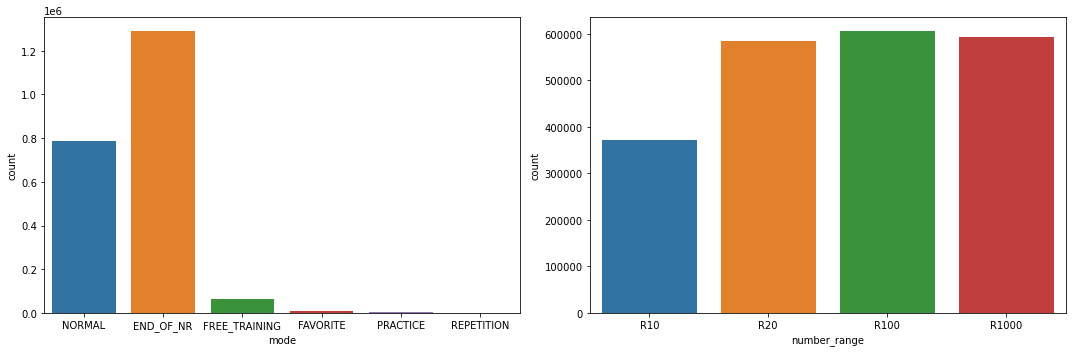

In [4]:
fig, axs = plt.subplots(1,2, figsize=(15, 5))
sns.countplot(data = pd.DataFrame(events['mode']), x = 'mode', ax = axs[0])
sns.countplot(data = pd.DataFrame(events['number_range']), x = 'number_range', ax = axs[1])
plt.tight_layout()
plt.show()

In [8]:
# Sort the dataframes per training mode: guided training (gt) and free training (ft)

events_gt = events[events['mode'].isin(['NORMAL', 'END_OF_NR', 'FAVORITE', 'REPETITION'])]
events_ft = events[events['mode'].isin(['FREE_TRAINING'])]
subtasks_gt = subtasks[subtasks['event_id'].isin(events_gt.index)]
subtasks_ft = subtasks[subtasks['event_id'].isin(events_ft.index)]
print(f'Length of GUIDED training events dataframe: {len(events_gt)}\nLength of GUIDED training subtasks dataframe: {len(subtasks_gt)}')
print(f'Length of FREE training events dataframe: {len(events_ft)}\nLength of FREE training subtasks dataframe: {len(subtasks_ft)}')
print(f'Users in guided: {len(events_gt["user_id"].unique())} and in free training: {len(events_ft["user_id"].unique())}')

Length of GUIDED training events dataframe: 2085189
Length of GUIDED training subtasks dataframe: 3358682
Length of FREE training events dataframe: 63447
Length of FREE training subtasks dataframe: 133400
Users in guided: 59817 and in free training: 8137


In [5]:
def create_events_subtasks(mode):
    if (mode == 'guided'):
        df_events = events_gt
        df_subtasks = subtasks_gt
    elif (mode == 'free'):
        df_events = events_ft
        df_subtasks = subtasks_ft
    else:
        raise ValueError("Incorrect mode selected: either guided or free")
    return df_events, df_subtasks

def create_smaller_dataset(events, subtasks, nb_of_considered_users):
    #random sample on users
    different_users = np.array(events['user_id'].unique())
    users_rng = np.random.choice(different_users, nb_of_considered_users, replace = False)
    events_small = events.loc[events['user_id'].isin(users_rng)]
    subtasks_small = subtasks.loc[subtasks['user_id'].isin(users_rng)]
    return events_small, subtasks_small

def add_week_dimension(df_events, df_subtasks):
    events_copy = df_events.copy()
    subtasks_copy = df_subtasks.copy()
    
    years = pd.to_datetime(events_copy['start'], infer_datetime_format=True).dt.isocalendar().year
    first_year = years.min()
    events_copy["week"] = pd.to_datetime(events_copy['start'], infer_datetime_format=True).dt.isocalendar().year-first_year
    events_copy["week"] = events_copy["week"]*WEEKS_A_YEAR +pd.to_datetime(events_copy['start'], infer_datetime_format=True).dt.isocalendar().week
    start_weeks = pd.Series(events_copy.groupby(by="user_id").min()["week"], name="start_weeks")
    subtasks_copy["week"] = pd.to_datetime(subtasks_copy['subtask_finished_timestamp'], infer_datetime_format=True).dt.isocalendar().year-first_year
    subtasks_copy["week"] = subtasks_copy["week"]*WEEKS_A_YEAR+pd.to_datetime(subtasks_copy['subtask_finished_timestamp'], infer_datetime_format=True).dt.isocalendar().week
    # Now actually change it to each user starting with week 0
    for user, start in start_weeks.items():
        events_copy.loc[events_copy["user_id"] == user, "week"] = events_copy[events_copy["user_id"] == user]["week"]-start
        subtasks_copy.loc[subtasks_copy["user_id"] == user, "week"] = subtasks_copy[subtasks_copy["user_id"] == user]["week"]-start
    return events_copy, subtasks_copy

In [10]:
# Effort features
def effort_features(df_events, df_subtasks):
  # Total time learning per week
  time_online = df_events.groupby(by=["user_id", "week"]).sum()["learning_time_ms"]
  #print(time_online.head())
  # TODO maybe total time online per week?

  # Total interactions per week, here interactions we define as events and weeks
  events_done = pd.Series(df_events.groupby(by=["user_id", "week"]).count()["skill_id"], name="events_done")
  #sns.histplot(events_done)
  #plt.show()

  subtasks_done = pd.Series(df_subtasks.groupby(by=["user_id", "week"]).count()["event_id"], name="subtasks_done")
  #sns.histplot(subtasks_done)
  #plt.show()
  
  # features Maxime
  df_events['difficulty'] = df_events['number_range'].replace({'R10': 1, 'R20': 2, 'R100': 3, 'R1000': 4})
  features = pd.DataFrame()
  features['Nb_of_different games'] = df_events.groupby(['user_id', 'week'])['game_name'].unique().apply(lambda example : len(example))
  features['correct'] = df_subtasks.groupby(['user_id','week'])['correct'].apply(lambda example: sum(example)/len(example))
  features['avg_difficulty'] = df_events.groupby(['user_id','week'])['difficulty'].mean()

  effort = pd.DataFrame({
    "time_online": time_online,  
    "events_done": events_done,  
    "subtasks_done": subtasks_done,
    "Nb_of_different games": features['Nb_of_different games'],  
    "correct": features['correct'],
    #  "avg_difficulty": features['avg_difficulty']   # Vivi's feature contains this
    })
  return effort

In [11]:
# Assessment feature
def assessment_features(df_events, df_subtasks):
    # Parse ranges in two different ways. TODO: choose which one makes more sense
    df_events['range_linear']  = df_events['number_range'].replace({'R10': 1, 'R20': 2, 'R100': 3, 'R1000': 4})
    df_events['range_default'] = df_events['number_range'].replace({'R10': 10, 'R20': 20, 'R100': 100, 'R1000': 1000})

    # assessment['num_attempts'] = subtasks.groupby(['user_id','week'])['event_id'].count()
    # assessment = assessment.merge(events['user_id', 'week', 'range_linear', 'range_default'], on= ['user_id', 'week'], how='left')

    # Number of attempts per user and week on every event
    subtasks_count = df_subtasks.groupby(['user_id','week', 'event_id']).size().reset_index().rename(columns={0: 'user_num_attempts'})
    user_assessment = df_events.merge(subtasks_count, on=['user_id','week', 'event_id'])[['event_id','user_id', 'week', 'range_linear', 'range_default', 'user_num_attempts']]

    # Number of unique users per subtask
    # TODO: check whether num_users_per_subtask is correct bc weird results with small dataset
    # Checking by 
    # user_assessment.groupby('user_id')['event_id'].count().rename('events_count').reset_index()
    # subtasks[subtasks['event_id'] == 0]
    num_users_per_subtask = df_subtasks.groupby('event_id')['user_id'].nunique()
    num_users_per_subtask.reset_index()
    # Events played by user
    # events_per_user = user_assessment.groupby('user_id')['event_id'].count().rename('idk_count').reset_index()

    # Can we know users played by users? find unique event_id by user_id in subtasks?
    # subtasks.groupby(['event_id', 'user_id']).count().reset_index().merge(subtasks, on= ['event_id', 'user_id'], how= 'left')

    # Average assessment feature (for all users)
    num_users_tried = df_subtasks.groupby('event_id')['user_id'].nunique().rename('num_users_tried').reset_index() # TODO: check its correct
    # avg_assessment_lin
    # Linear range
    min_range_lin = user_assessment.groupby('event_id')['range_linear'].min().rename('min_range_lin').reset_index()
    avg_range_lin = user_assessment.groupby('event_id')['range_linear'].mean().rename('avg_range_lin').reset_index()
    max_range_lin = user_assessment.groupby('event_id')['range_linear'].max().rename('max_range_lin').reset_index()

    ev_copy = df_events[['range_linear', 'range_default']]
    avg_assessment_lin = ev_copy.merge(min_range_lin, on='event_id')
    avg_assessment_lin = avg_assessment_lin.merge(avg_range_lin, on='event_id')
    avg_assessment_lin = avg_assessment_lin.merge(max_range_lin, on='event_id')
    avg_assessment_lin = avg_assessment_lin.merge(num_users_tried, on='event_id')

    avg_assessment_lin = avg_assessment_lin[['event_id', 'min_range_lin', 'avg_range_lin', 'max_range_lin', 'range_linear', 'num_users_tried']]


    # Default range
    min_range_def = user_assessment.groupby('event_id')['range_default'].min().rename('min_range_def').reset_index()
    avg_range_def = user_assessment.groupby('event_id')['range_default'].mean().rename('avg_range_def').reset_index()
    max_range_def = user_assessment.groupby('event_id')['range_default'].max().rename('max_range_def').reset_index()

    avg_assessment_def = ev_copy.merge(min_range_def, on='event_id')
    avg_assessment_def = avg_assessment_def.merge(avg_range_def, on='event_id')
    avg_assessment_def = avg_assessment_def.merge(max_range_def, on='event_id')
    avg_assessment_def = avg_assessment_def.merge(num_users_tried, on='event_id')

    avg_assessment_def = avg_assessment_def[['event_id', 'min_range_def', 'avg_range_def', 'max_range_def', 'range_default', 'num_users_tried']]

    # Average assessment feature (for all users)
    num_users_tried = df_subtasks.groupby('event_id')['user_id'].nunique().rename('num_users_tried').reset_index() # TODO: check its correct
    # avg_assessment_lin
    # Linear range
    min_range_lin = user_assessment.groupby('event_id')['range_linear'].min().rename('min_range_lin').reset_index()
    avg_range_lin = user_assessment.groupby('event_id')['range_linear'].mean().rename('avg_range_lin').reset_index()
    max_range_lin = user_assessment.groupby('event_id')['range_linear'].max().rename('max_range_lin').reset_index()

    ev_copy = df_events[['range_linear', 'range_default']]
    avg_assessment_lin = ev_copy.merge(min_range_lin, on='event_id')
    avg_assessment_lin = avg_assessment_lin.merge(avg_range_lin, on='event_id')
    avg_assessment_lin = avg_assessment_lin.merge(max_range_lin, on='event_id')
    avg_assessment_lin = avg_assessment_lin.merge(num_users_tried, on='event_id')

    avg_assessment_lin = avg_assessment_lin[['event_id', 'min_range_lin', 'avg_range_lin', 'max_range_lin', 'range_linear', 'num_users_tried']]


    # Default range
    min_range_def = user_assessment.groupby('event_id')['range_default'].min().rename('min_range_def').reset_index()
    avg_range_def = user_assessment.groupby('event_id')['range_default'].mean().rename('avg_range_def').reset_index()
    max_range_def = user_assessment.groupby('event_id')['range_default'].max().rename('max_range_def').reset_index()

    avg_assessment_def = ev_copy.merge(min_range_def, on='event_id')
    avg_assessment_def = avg_assessment_def.merge(avg_range_def, on='event_id')
    avg_assessment_def = avg_assessment_def.merge(max_range_def, on='event_id')
    avg_assessment_def = avg_assessment_def.merge(num_users_tried, on='event_id')

    avg_assessment_def = avg_assessment_def[['event_id', 'min_range_def', 'avg_range_def', 'max_range_def', 'range_default', 'num_users_tried']]

    # Left join between users_assessment and average_assessment
    user_assessment = user_assessment.merge(avg_assessment_lin, how='left')

    # Attempts_diff gives you a intuition on how is the user doing in comparison with other users
    user_assessment['attempts_diff_lin'] = user_assessment['user_num_attempts'] - user_assessment['avg_range_lin']

    user_assessment = user_assessment.merge(avg_assessment_def, how='left')

    # Attempts_diff gives you a intuition on how is the user doing in comparison with other users
    user_assessment['attempts_diff_def'] = user_assessment['user_num_attempts'] - user_assessment['avg_range_def']
    range_linear = user_assessment.groupby(['user_id', 'week']).count()['range_linear']
    # range_linear.tail(20)

    # Assessment pipeline for linear and default difficulty range

    user_num_attempts = user_assessment.groupby(['user_id', 'week'])['user_num_attempts'].mean()
    num_users_tried = user_assessment.groupby(['user_id', 'week'])['num_users_tried'].mean()

    range_linear = user_assessment.groupby(['user_id', 'week'])['range_linear'].mean()
    attempts_diff_lin = user_assessment.groupby(['user_id', 'week'])['attempts_diff_lin'].mean()
    min_range_lin = user_assessment.groupby(['user_id', 'week'])['min_range_lin'].mean()
    avg_range_lin = user_assessment.groupby(['user_id', 'week'])['avg_range_lin'].mean()
    max_range_lin = user_assessment.groupby(['user_id', 'week'])['max_range_lin'].mean()

    assessment_lin = pd.DataFrame({
        "range_linear":  range_linear,
        "user_num_attempts": user_num_attempts,
        "num_users_tried": num_users_tried,
        "attempts_diff": attempts_diff_lin,
        "min_range_lin": min_range_lin,
        "avg_range_lin": avg_range_lin,
        "max_range_lin": max_range_lin,
    })

    range_default = user_assessment.groupby(['user_id', 'week'])['range_default'].mean()
    attempts_diff_def = user_assessment.groupby(['user_id', 'week'])['attempts_diff_lin'].mean()
    min_range_def = user_assessment.groupby(['user_id', 'week'])['min_range_def'].mean()
    avg_range_def = user_assessment.groupby(['user_id', 'week'])['avg_range_def'].mean()
    max_range_def = user_assessment.groupby(['user_id', 'week'])['max_range_def'].mean()

    assessment_def = pd.DataFrame({
        "range_linear":  range_linear,
        "user_num_attempts": user_num_attempts,
        "num_users_tried": num_users_tried,
        "attempts_diff": attempts_diff_def,
        "min_range_def": min_range_def,
        "avg_range_def": avg_range_def,
        "max_range_def": max_range_def,
    })

    return assessment_lin, assessment_def

In [50]:
# Preprocessing pipeline
training_mode = 'guided'
df_events, df_subtasks = create_events_subtasks(training_mode)
df_events, df_subtasks = create_smaller_dataset(df_events, df_subtasks, nb_of_considered_users = 59817) #there might not be enough users for free training if number too big
df_events, df_subtasks = add_week_dimension(df_events, df_subtasks)

In [51]:
effort = effort_features(df_events, df_subtasks)
effort.head()

time_online  events_done  subtasks_done  Nb_of_different games  \
user_id week                                                                   
2       0         28973.0            2            3.0                      2   
        1         22240.0            4            5.0                      3   
        2         18282.0            3            3.0                      3   
        3         19819.0            3            3.0                      1   
        4         92688.0            5            5.0                      3   

               correct  
user_id week            
2       0     0.666667  
        1     1.000000  
        2     1.000000  
        3     0.666667  
        4     0.400000

In [52]:
assessment_lin, assessment_def = assessment_features(df_events, df_subtasks)
assessment_lin.head()

range_linear  user_num_attempts  num_users_tried  attempts_diff  \
user_id week                                                                    
2       0              1.0               1.50              1.0           0.50   
        1              1.5               1.25              1.0          -0.25   
        2              2.0               1.00              1.0          -1.00   
        3              3.0               1.00              1.0          -2.00   
        4              3.0               1.00              1.0          -2.00   

              min_range_lin  avg_range_lin  max_range_lin  
user_id week                                               
2       0               1.0            1.0            1.0  
        1               1.5            1.5            1.5  
        2               2.0            2.0            2.0  
        3               3.0            3.0            3.0  
        4               3.0            3.0            3.0

In [53]:
print(f"Count of users in effort: {len(effort.index.get_level_values('user_id').unique())}")
print(f"Count of users in assessment: {len(assessment_lin.index.get_level_values('user_id').unique())}")

Count of users in effort: 59817
Count of users in assessment: 51891


*Your discussion about your processing decisions goes here*

Given the response by the StartUp that all "[...] modes (NORMAL, END_OF_NR, REPETITION, FAVORITE) are all part of guided training", we decided to make a split exactly along those game modes (on one side the all students that do guided traning and on the other side all students doing free training).
Further, as we want to do time-series clustering, we create each of the features possible from the "Identifying and comparing multi-dimensional student profiles across flipped classroom" paper per week (necessating the addition of week per event, describing the n'th week this student did a particular event, starting from 0 for each student when they logged in for the first time.)
Applying the assessment feature to our dataset was much more difficult than initially thought, but we ended up taking all basic skills as the same difficulty (e.g. addition, division) and pulling in on which number line this basic skill was tried.

The subsampling of our dataset was necessary because of the incredibly slow runtimes for the tslearn TimeSeriesKMeans (and initially also the spectral clustering).

## Task 2: Model Building

Train a model for your research question. 

In [54]:
# Your code for training a model goes here

# Combine all features and for now use the complete first 15 weeks (later also with 15 active weeks)
combined_features = effort[effort.index.get_level_values(1) <= WEEKS]
combined_features['attempts_diff'] = assessment_lin[assessment_lin.index.get_level_values(1) <= WEEKS]['attempts_diff']

combined_features.head()

/tmp/ipykernel_3577/3977808626.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  combined_features['attempts_diff'] = assessment_lin[assessment_lin.index.get_level_values(1) <= WEEKS]['attempts_diff']


time_online  events_done  subtasks_done  Nb_of_different games  \
user_id week                                                                   
2       0         28973.0            2            3.0                      2   
        1         22240.0            4            5.0                      3   
        2         18282.0            3            3.0                      3   
        3         19819.0            3            3.0                      1   
        4         92688.0            5            5.0                      3   

               correct  attempts_diff  
user_id week                           
2       0     0.666667           0.50  
        1     1.000000          -0.25  
        2     1.000000          -1.00  
        3     0.666667          -2.00  
        4     0.400000          -2.00

Simpler direct application of tslearn k-means to the raw set of our features.

In [55]:
reshaped_feature = pd.DataFrame(combined_features, copy=True).fillna(0)
print(f"Each element will be a list of {reshaped_feature.columns.values} features")
# Create a combined feater list and unstack it
reshaped_feature["combined"] = reshaped_feature.values.tolist()
reshaped_feature = reshaped_feature["combined"].unstack(level=1)
# Sort columns by week, as now it is a time series
reshaped_feature = reshaped_feature.reindex(sorted(reshaped_feature.columns), axis=1)
reshaped_feature.head(2)

Each element will be a list of ['time_online' 'events_done' 'subtasks_done' 'Nb_of_different games'
 'correct' 'attempts_diff'] features


week,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
user_id,,,,,,,,,,,,,,,,
2,"[28973.0, 2.0, 3.0, 2.0, 0.6666666666666666, 0.5]","[22240.0, 4.0, 5.0, 3.0, 1.0, -0.25]","[18282.0, 3.0, 3.0, 3.0, 1.0, -1.0]","[19819.0, 3.0, 3.0, 1.0, 0.6666666666666666, -...","[92688.0, 5.0, 5.0, 3.0, 0.4, -2.0]","[100238.0, 6.0, 6.0, 4.0, 0.3333333333333333, ...","[49964.0, 4.0, 4.0, 2.0, 0.75, -2.0]","[30434.0, 5.0, 6.0, 3.0, 0.8333333333333334, -...",NaN,"[10356.0, 3.0, 5.0, 2.0, 0.8, -1.3333333333333...","[36035.0, 3.0, 4.0, 3.0, 0.25, -1.333333333333...","[122067.0, 6.0, 15.0, 5.0, 0.8, -0.33333333333...","[246957.0, 9.0, 20.0, 5.0, 0.95, -0.5555555555...","[89011.0, 5.0, 5.0, 4.0, 1.0, -2.8]","[53285.0, 5.0, 7.0, 2.0, 0.42857142857142855, ...","[59922.0, 3.0, 3.0, 3.0, 0.6666666666666666, -..."
3,"[89136.0, 5.0, 8.0, 5.0, 0.625, 0.2]","[54265.0, 5.0, 6.0, 3.0, 0.5, -1.0]","[15163.0, 2.0, 2.0, 1.0, 0.5, -2.0]","[49803.0, 5.0, 5.0, 3.0, 0.4, -2.0]","[65637.0, 4.0, 6.0, 4.0, 1.0, -1.5]","[30315.0, 3.0, 3.0, 2.0, 0.6666666666666666, -...","[2994.0, 1.0, 2.0, 1.0, 1.0, -2.0]",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[3698.0, 1.0, 2.0, 1.0, 1.0, -2.0]"


In [56]:
# Fill missing values with NaN filler list --> impossible to do in a smarter way
nan_filler_list = np.array([0] * len(combined_features.columns))
arr = reshaped_feature.values
nan_mask = np.vectorize(lambda x: isinstance(x, float) and np.isnan(x))(arr)
for i in range(len(arr)):
    for j in range(len(arr[i])):
        if nan_mask[i][j]:
            arr[i][j] = nan_filler_list
        else:
            arr[i][j] = np.array(arr[i][j])
            
arr = np.array([np.stack(x) for x in arr])

In [57]:
# Multivariate time series clustering using normal DTW
def find_k():
    print("DBA k-means for multivariate clustering")
    silhouette_list = []
    distortion_list = []
    rang = range(2, 10)
    for clusters in rang:
        print(f"Doing now with {clusters} clusters.")
        dba_km = TimeSeriesKMeans(n_clusters=clusters,
                              #n_init=2,
                              metric="dtw",
                              verbose=False,
                              n_jobs=-1,
                              max_iter_barycenter=50,
                              random_state=69)
        y_pred = dba_km.fit_predict(arr)
        distortion = dba_km.inertia_
        distortion_list.append(distortion)
        ss = silhouette_score(arr, y_pred)
        silhouette_list.append(ss)

    sns.lineplot(x=rang, y=silhouette_list)
    sns.lineplot(x=rang, y=distortion_list)
    plt.show()
#find_k()

In [58]:
# Multivariate time series clustering using soft DTW
def find_k():
    print("softdtw k-means for multivariate clustering")
    silhouette_list = []
    distortion_list = []
    rang = range(2, 11)
    for clusters in rang:
        print(f"Doing now with {clusters} clusters.")
        dba_km = TimeSeriesKMeans(n_clusters=clusters,
                              #n_init=2,
                              metric="softdtw",
                              metric_params={"gamma": .5},
                              verbose=False,
                              n_jobs=-1,
                              max_iter_barycenter=50,
                              random_state=69)
        y_pred = dba_km.fit_predict(arr)
        distortion = dba_km.inertia_
        distortion_list.append(distortion)
        ss = silhouette_score(arr, y_pred)
        silhouette_list.append(ss)

    sns.lineplot(x=rang, y=silhouette_list)
    sns.lineplot(x=rang, y=distortion_list)
    plt.show()
#find_k()

*Your discussion about your model training goes here*

Because the silhouette_score similarly to the similarity matrix takes polynomially more time in the number of students, it is infeasable to run these find_k for big number of students.
tslearn's TimeSeriesKMeans is able to run across all of the students within a day (different runs took different times, but roughly on the order of 10 hours on an 8 core server with 40 GB of RAM), but for the full dataset has the issue of clustering single outliers by themselves.
As each of those runs takes very long (and we didn't notice that the silhouette_score won't ever finish in time too late), we did not manage to re-run all of the students after doing some outlier detection and removal.

## Task 3: Model Evaluation
In this task, you will use metrics to evaluate your model.

In [60]:
K = 6
USE_SOFT_DTW = True
if USE_SOFT_DTW:
    dba_km = TimeSeriesKMeans(n_clusters=K,
                          #n_init=2,
                          metric="softdtw",
                          metric_params={"gamma": .5},
                          verbose=True,
                          max_iter_barycenter=50,
                          n_jobs=-1,
                          random_state=69)
else:
    dba_km = TimeSeriesKMeans(n_clusters=K,
                        metric="dtw",
                        verbose=True,
                        n_jobs=-1,
                        max_iter_barycenter=50,
                        random_state=69)
y_pred = dba_km.fit_predict(arr)
print("Done the fitting!")

8920771938661717147385856.000 --> 8393309415954202329350144.000 --> 6621163184130418502795264.000 --> 6621144822836487599947776.000 --> 6621125527547115472945152.000 --> 6621105886657831164182528.000 --> 6621086124120124399026176.000 --> 6621065963333292025446400.000 --> 6621042702567601959075840.000 --> 6621019929202365153935360.000 --> 6620998829739508137721856.000 --> 6620979223873401500205056.000 --> 6620960645265150600806400.000 --> 6620944161656034459385856.000 --> 6620928961208137182871552.000 --> 6620917605151312976019456.000 --> 6620907786421075737313280.000 --> 6620908292327354444808192.000 --> 6620909043695104001310720.000 --> 6620908991832674896183296.000 --> 6620909008044006406356992.000 --> 6620908742285924570759168.000 --> 6620908549859150126907392.000 --> 6620907700938483378946048.000 --> 6620907606371809703755776.000 --> 6620908932373896048410624.000 --> 6620909242126184742912000.000 --> 6620910592466286312161280.000 --> 6620910524960735911477248.000 --> 66209104944339

In [61]:
if len(arr) > 500:
    print("silhouette_score is super slow, not calculated!")
    ss = None
else:
    ss = silhouette_score(arr, y_pred)

silhouette_score is super slow, not calculated!


In [7]:
# Now lets look at these baricenters for those clusters per feature
def flatten(l):
    return [item for sublist in l for item in sublist]

def make_rgb_transparent(rgb, bg_rgb, alpha):
    return [alpha * c1 + (1 - alpha) * c2
            for (c1, c2) in zip(rgb, bg_rgb)]

In [3]:
def save_clustering(name):
    # pickle both the model and the scaler as a single file
    with open(name, 'wb') as f:
        ids = combined_features.index.get_level_values(0).unique()
        pickle.dump((arr, y_pred, dba_km, combined_features, K, ss, ids), f)
#save_clustering('clusteringHalf.pickle')

def load_clustering(name='clustering.pickle'):
    # First load the model and the scaler, return it as singletons
    with open(name, 'rb') as f:
        (arr, y_pred, dba_km, combined_features, K, ss, ids) = pickle.load(f)
        print(f"Loaded a save of {len(ids)} students!")
        return arr, y_pred, dba_km, combined_features, K, ss

In [4]:
qualitative_colors = sns.color_palette("Set3", 10)
def color_map(x):
    color = {
        1: qualitative_colors[1],
        2: qualitative_colors[2],
        3: qualitative_colors[3],
        4: qualitative_colors[4],
        5: qualitative_colors[5],
        6: qualitative_colors[6],
        7: qualitative_colors[7],
        8: qualitative_colors[8],
        9: qualitative_colors[0],
    }
    return color.get(x%10, qualitative_colors[0])

##### Clusters of free training students

In [8]:
arr, y_pred, dba_km, combined_features, K, ss = load_clustering('../dataSaves/clusteringFree.pickle')
counts = np.unique(y_pred, return_counts=True)
for clu, cnt in zip(counts[0], counts[1]):
    print(f"Cluster {clu} has {cnt:3} users")

Loaded a save of 8137 students!
Cluster 0 has 6485 users
Cluster 1 has 360 users
Cluster 2 has 157 users
Cluster 3 has   2 users
Cluster 4 has 1129 users
Cluster 5 has   4 users


Baricenters shape: (6, 16, 6)
All features: ['time_online' 'events_done' 'subtasks_done' 'Nb_of_different games'
 'correct' 'attempts_diff']
Looking at baricenter of feature time_online for free training


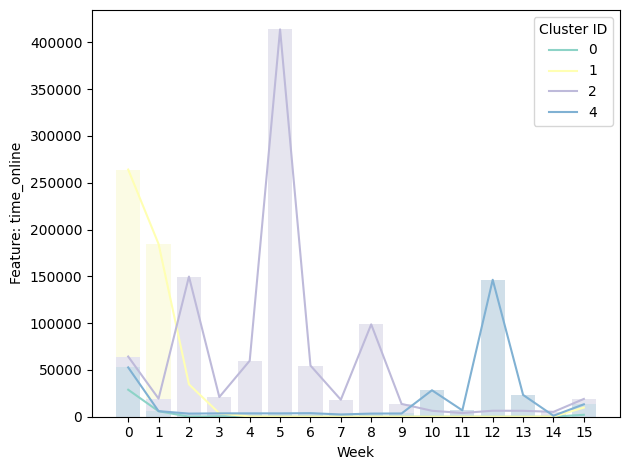

Looking at baricenter of feature events_done for free training


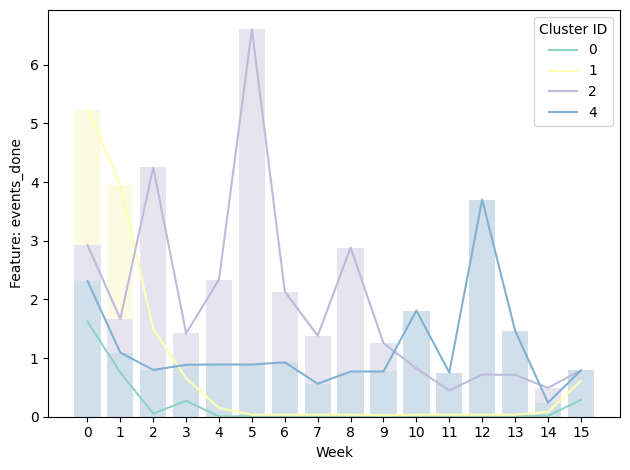

Looking at baricenter of feature subtasks_done for free training


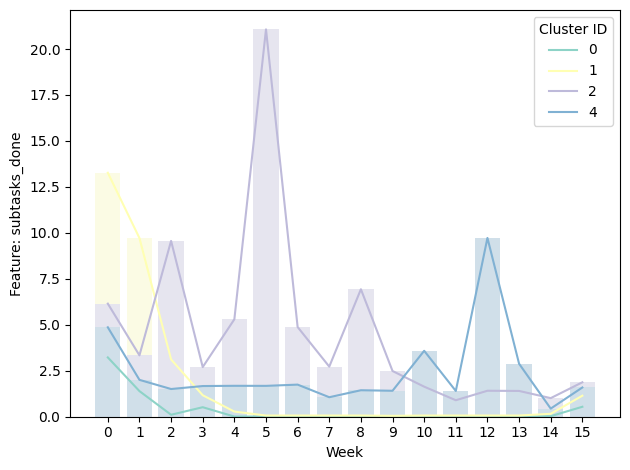

Looking at baricenter of feature Nb_of_different games for free training


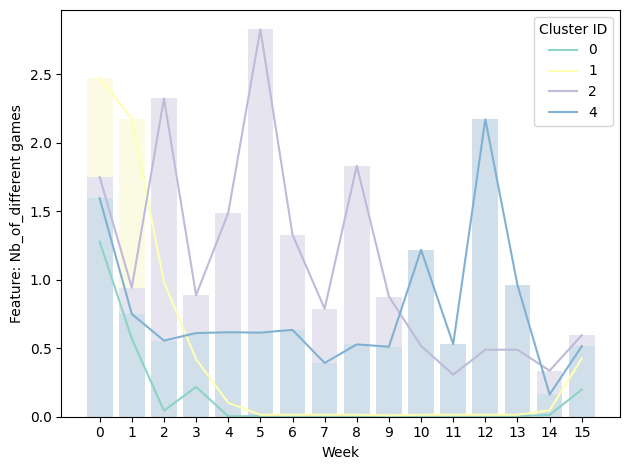

Looking at baricenter of feature correct for free training


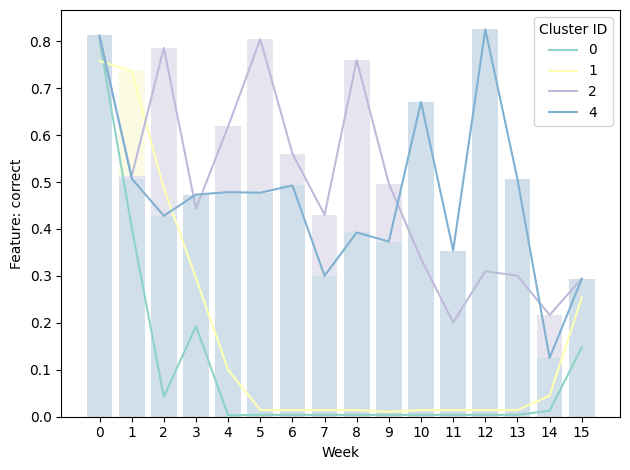

Looking at baricenter of feature attempts_diff for free training


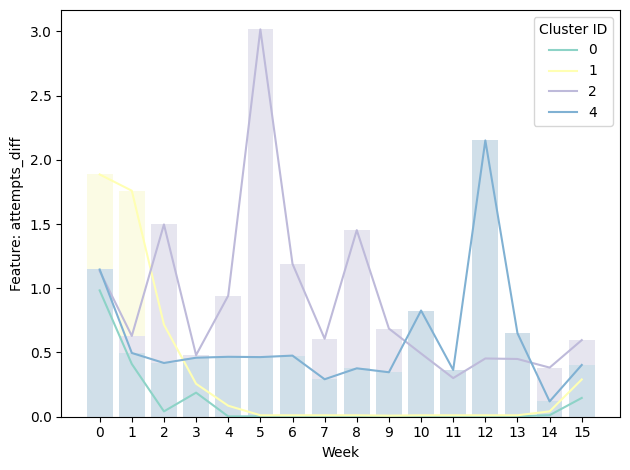

In [9]:
# Lets choose cluster to look at which don't single digit number of students
clusters = [0, 1, 2, 4]

# Print the shape of the baricenters
print(f"Baricenters shape: {dba_km.cluster_centers_.shape}")
#For each cluster we can at the full timeseries for each feature
feature_names = combined_features.columns.values 
print(f"All features: {feature_names}")
alpha = 0.4
for i in range(0, len(feature_names)):
    print(f"Looking at baricenter of feature {feature_names[i]} for free training")
    # Make a form out of the baricenters that seaborn can plot
    dt_frame = pd.DataFrame({
        f"Feature: {feature_names[i]}": flatten([dba_km.cluster_centers_[cluster, :, i].tolist() for cluster in clusters]),
        "Week": flatten([range(0, WEEKS+1) for _ in clusters]),
        "Cluster": flatten([[cluster]*(WEEKS+1) for cluster in clusters]),
    })
    sns.color_palette('bright')
    ax = plt.subplots()
    for cluster in clusters:
        ax = sns.barplot(x=dt_frame[dt_frame["Cluster"] == cluster]["Week"], 
                         y=dt_frame[dt_frame["Cluster"] == cluster][f"Feature: {feature_names[i]}"],
                         color=make_rgb_transparent(color_map(cluster), (1,1,1), alpha), hue_order=dt_frame.sort_values("Cluster"))
    for cluster in clusters:
        ax = sns.lineplot(x=dt_frame[dt_frame["Cluster"] == cluster]["Week"], 
                         y=dt_frame[dt_frame["Cluster"] == cluster][f"Feature: {feature_names[i]}"],
                         color=color_map(cluster))
    ax.legend(handles=ax.lines[-4:], labels=clusters, title="Cluster ID")
    plt.xlabel('Week')
    plt.tight_layout()
    plt.savefig(f"figures/free_baricenter_{feature_names[i]}.png", dpi=300)
    plt.show()

##### Clusters of guided training students

In [10]:
arr, y_pred, dba_km, combined_features, K, ss = load_clustering('../dataSaves/clusteringHalf.pickle')
counts = np.unique(y_pred, return_counts=True)
for clu, cnt in zip(counts[0], counts[1]):
    print(f"Cluster {clu} has {cnt:3} users")

Loaded a save of 25000 students!
Cluster 0 has 24995 users
Cluster 1 has   1 users
Cluster 2 has   1 users
Cluster 3 has   1 users
Cluster 4 has   1 users
Cluster 5 has   1 users


Baricenters shape: (6, 16, 6)
All features: ['time_online' 'events_done' 'subtasks_done' 'Nb_of_different games'
 'correct' 'attempts_diff']
Looking at baricenter of feature time_online for guided training


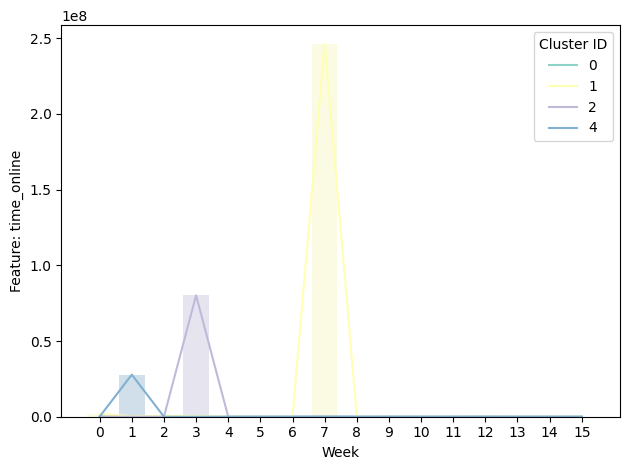

Looking at baricenter of feature events_done for guided training


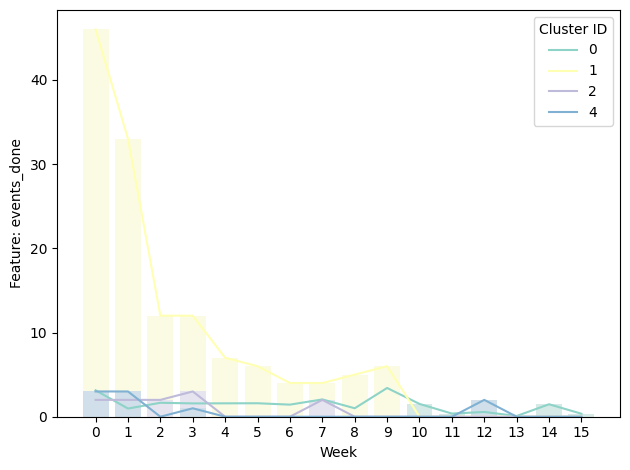

Looking at baricenter of feature subtasks_done for guided training


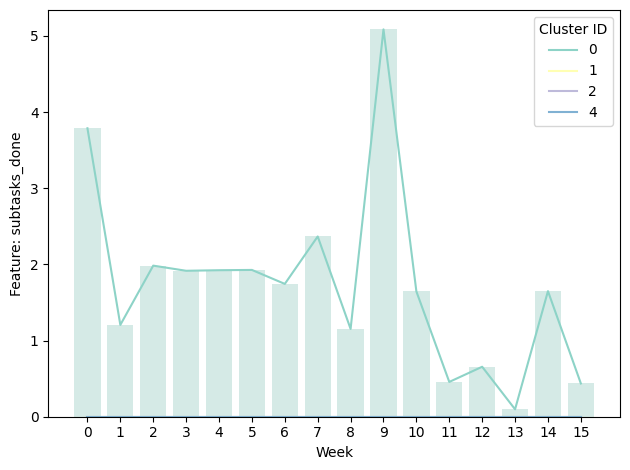

Looking at baricenter of feature Nb_of_different games for guided training


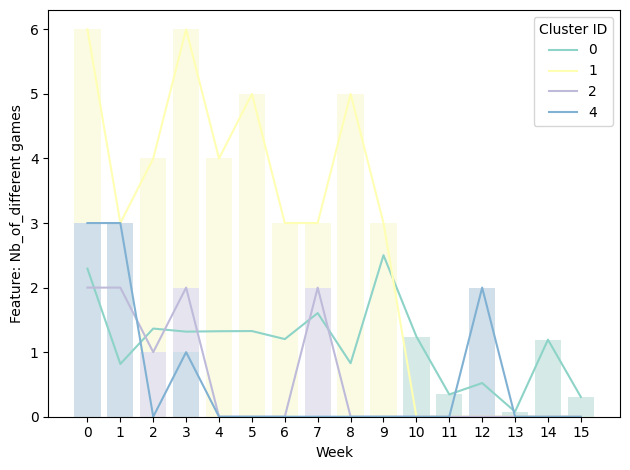

Looking at baricenter of feature correct for guided training


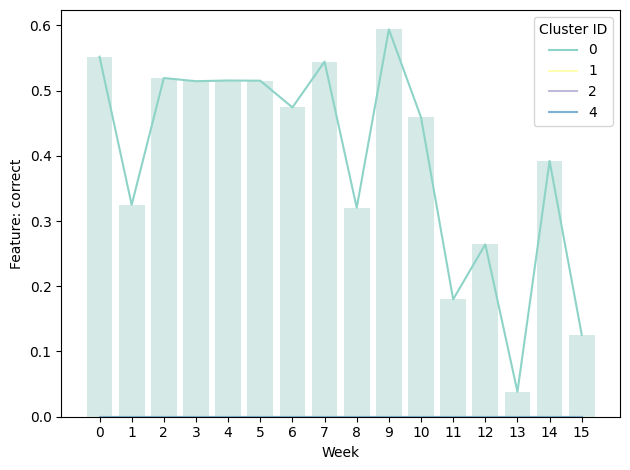

Looking at baricenter of feature attempts_diff for guided training


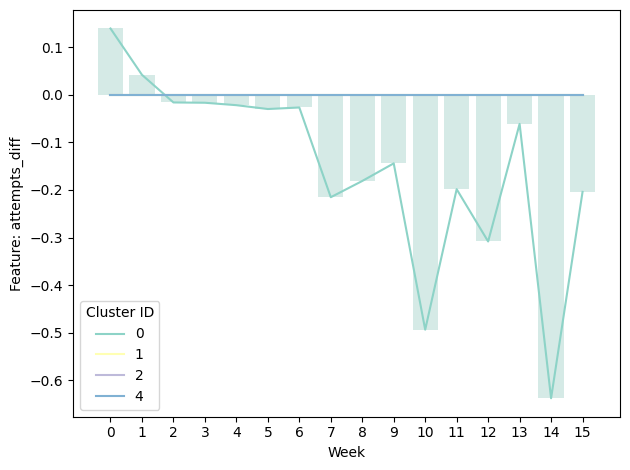

In [11]:
# Lets choose cluster to look at which don't single digit number of students
clusters = [0, 1, 2, 4]

# Print the shape of the baricenters
print(f"Baricenters shape: {dba_km.cluster_centers_.shape}")
#For each cluster we can at the full timeseries for each feature
feature_names = combined_features.columns.values 
print(f"All features: {feature_names}")
alpha = 0.4
for i in range(0, len(feature_names)):
    print(f"Looking at baricenter of feature {feature_names[i]} for guided training")
    # Make a form out of the baricenters that seaborn can plot
    dt_frame = pd.DataFrame({
        f"Feature: {feature_names[i]}": flatten([dba_km.cluster_centers_[cluster, :, i].tolist() for cluster in clusters]),
        "Week": flatten([range(0, WEEKS+1) for _ in clusters]),
        "Cluster": flatten([[cluster]*(WEEKS+1) for cluster in clusters]),
    })
    sns.color_palette('bright')
    ax = plt.subplots()
    for cluster in clusters:
        ax = sns.barplot(x=dt_frame[dt_frame["Cluster"] == cluster]["Week"], 
                         y=dt_frame[dt_frame["Cluster"] == cluster][f"Feature: {feature_names[i]}"],
                         color=make_rgb_transparent(color_map(cluster), (1,1,1), alpha), hue_order=dt_frame.sort_values("Cluster"))
    for cluster in clusters:
        ax = sns.lineplot(x=dt_frame[dt_frame["Cluster"] == cluster]["Week"], 
                         y=dt_frame[dt_frame["Cluster"] == cluster][f"Feature: {feature_names[i]}"],
                         color=color_map(cluster))
    ax.legend(handles=ax.lines[-4:], labels=clusters, title="Cluster ID")
    plt.xlabel('Week')
    plt.tight_layout()
    plt.savefig(f"figures/guided_baricenter_{feature_names[i]}.png", dpi=300)
    plt.show()

*Your discussion/interpretation about your model's behavior goes here*

As can be seen in the plots of the different feature baricenters, the clusters seem to assign different types of students to the different clusters.
We can additionally see that the cluster of students that invest more time in training (looking at the time online), generally also have a higher percentage of correct (looking at correct) answers over their learning time.

When looking at the numbers of students per cluster assignment it seems that the initial full set of free students has too many outliers, which result in cluster 0 being the one used for almost all students, which during their initial few weeks do work regularly, but then stop working until week 14 or 15.
Still cluster 2 and 4 can be seen to differ strongly from the big set of cluster 0 and do work even in the weeks after the first few.



## Task 4: Team Reflection
Please describe the contributions of each team member to Milestone 4. Reflect on how you worked as team: what went well, what can be improved for the next milestone?

*Your discussion about team responsibilities goes here*

Contributions:
- Tobias: Initial implementation of the spectral clustering with dimensionality matrices, the initial effort feature and the regularity feature. For the K-Means implementation part of the effort feature, adding weeks, the clustering pipeline using tslearn (mainly data reshaping), parameter choosing (what metric & cluster amount), running the models in full and the initial plotting of our cluster results.
- Maxime: Some additional elements of the effort feature, as well as all of the subsampling to be able to run the rest of the pipeline in a more reasonable time.
- Violeta: The implementation of the complex assessment feature currently in use as well as all of the pretty plottuing for our cluster results. 

*What went well?*
The most sucessfull part for this milestone was writing the report.
That went very fast and efficiently, all members contributed different parts and flushed it out.
The discussions within the team of how we want to handle the fact that we cannot keep going with the spectral clustering went also well.

*What can be improved?*
Noone of our team managed to hit the deadlines we set ourselves.
This is also partly due to the fact that our initial implementation did end up running way too slow.
We still have to improve our time management and communication between dependencies.
One example could be working already on other extended features, even while the pipeline is not yet in working order.
